In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable

import PIL as PILLOW
from torchvision import transforms
from torchvision.datasets import MNIST

import copy

%matplotlib inline

In [2]:
train = MNIST('../DATASETS/MNIST_pytorch/', train=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
    ]),
#              download=True,
             )

test = MNIST('../DATASETS/MNIST_pytorch/', train=False, transform=transforms.ToTensor(),
#             download=True,
            )
# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=32)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [3]:
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Transformed Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1306)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [4]:
test_data = test.data
test_data = train.transform(test_data.numpy())

print('[Test]')
print(' - Numpy Shape:', test.data.numpy().shape)
print(' - Tensor Shape:', test.data.size())
print(' - Transformed Shape:', test_data.size())
print(' - min:', torch.min(test_data))
print(' - max:', torch.max(test_data))
print(' - mean:', torch.mean(test_data))
print(' - std:', torch.std(test_data))
print(' - var:', torch.var(test_data))

[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - Transformed Shape: torch.Size([28, 10000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1325)
 - std: tensor(0.3105)
 - var: tensor(0.0964)


## Normalized Network

In [21]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(784, 100)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 10)
        self.scaler = torch.ones(1, 10, requires_grad=True)
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        for layer in [self.fc1, self.fc2, self.fc3]:
            layer.weight.data /= torch.norm(layer.weight.data, dim=0)
        
        x = x.view((-1, 784))
        h = self.fc1(x)
        h = self.relu(h)        
        h = self.fc2(h)
        h = self.relu(h)
        h = self.fc3(h)
        h = h*self.scaler
        out = self.softmax(h)
        return out

In [22]:
model = Model()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [23]:
# model.train()
evaluate_x = Variable(test_loader.dataset.data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.targets)

losses = []
EPOCHS = 5
for epoch in range(EPOCHS):
    data_count = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = criterion(y_pred, target)
        losses.append(loss.data)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        data_count += len(data)
        if batch_idx%100 == 0 or batch_idx==len(train_loader)-1:
            output = model(evaluate_x)
            pred = output.max(1)[1]
            d = pred.eq(evaluate_y)
            accuracy = float(d.sum())/float(d.size()[0])
            
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                epoch, 
                data_count, 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data,
                accuracy,),
                end='')
            
    print()

 Train Epoch: 0 [60000/60000 (100%)]	Loss: 0.174188	Accuracy: 0.9525
 Train Epoch: 1 [60000/60000 (100%)]	Loss: 0.022945	Accuracy: 0.9658
 Train Epoch: 2 [60000/60000 (100%)]	Loss: 0.055203	Accuracy: 0.9689
 Train Epoch: 3 [60000/60000 (100%)]	Loss: 0.034965	Accuracy: 0.9707
 Train Epoch: 4 [60000/60000 (100%)]	Loss: 0.006296	Accuracy: 0.9727


(0.13572569, 0.18912715)

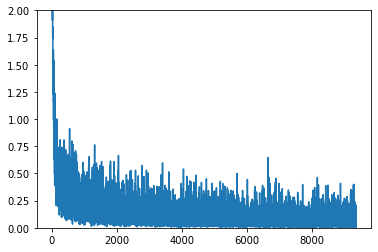

In [32]:
plt.plot(losses)
plt.ylim(0,2)
np.mean(losses), np.std(losses)

In [25]:
# model_copy = copy.deepcopy(model)
# model = model_copy

In [26]:
for model_parm in model.parameters():
        model_parm.requires_grad=False

In [27]:
evaluate_x = test.data.type_as(torch.FloatTensor())
evaluate_y = test_loader.dataset.targets


output = model(evaluate_x)
pred = output.max(dim=1)[1]
d = pred.eq(evaluate_y)
accuracy = float(d.sum())/float(d.size()[0])

print('Accuracy:', accuracy)

Accuracy: 0.9727


## Testing with un-normalized network

In [28]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        
        self.fc1 = nn.Linear(784, 100)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 10)
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
#         for layer in [self.fc1, self.fc2, self.fc3]:
#             layer.weight.data /= torch.norm(layer.weight.data, dim=0)
        
        x = x.view((-1, 784))
        h = self.fc1(x)
        h = self.relu(h)        
        h = self.fc2(h)
        h = self.relu(h)
        h = self.fc3(h)
        out = self.softmax(h)
        return out

In [29]:
model1 = Model1()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
criterion1 = nn.CrossEntropyLoss()

In [30]:
losses1 = []
EPOCHS = 5
for epoch in range(EPOCHS):
    data_count = 0
    for batch_idx, (data, target) in enumerate(train_loader):

        y_pred = model1(data) 
        loss = criterion1(y_pred, target)
        losses1.append(loss.data)
        
        # Backpropagation
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        
        # Display
        data_count += len(data)
        if batch_idx%100 == 0 or batch_idx==len(train_loader)-1:
            output = model1(evaluate_x)
            pred = output.max(1)[1]
            d = pred.eq(evaluate_y)
            accuracy = float(d.sum())/float(d.size()[0])
            
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}  '.format(
                epoch, 
                data_count, 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data,
                accuracy,),
                end='')
            
    print()

 Train Epoch: 0 [60000/60000 (100%)]	Loss: 0.185567	Accuracy: 0.9467  
 Train Epoch: 1 [60000/60000 (100%)]	Loss: 0.117592	Accuracy: 0.9603  
 Train Epoch: 2 [60000/60000 (100%)]	Loss: 0.234222	Accuracy: 0.97   
 Train Epoch: 3 [60000/60000 (100%)]	Loss: 0.420092	Accuracy: 0.9692  
 Train Epoch: 4 [60000/60000 (100%)]	Loss: 0.036307	Accuracy: 0.9715  


(0.15151781, 0.19681089)

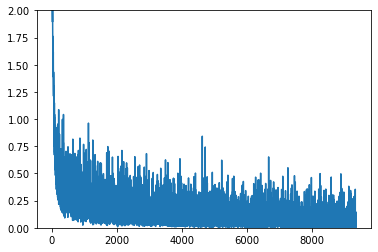

In [33]:
plt.plot(losses1)
plt.ylim(0,2)
np.mean(losses1), np.std(losses1)

In [34]:
output = model1(evaluate_x)
pred = output.max(1)[1]
d = pred.eq(evaluate_y)
accuracy = float(d.sum())/float(d.size()[0])
accuracy

0.9715